--- Network ---
DeepRitzNet(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=64, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (final_linear): Linear(in_features=64, out_features=1, bias=True)
)
Params: 12737
Technique: SIREN + Sobol Sampling + CosineAnnealing
Running Adam (Sobol Sampling)...
Epoch 2500/50000 Loss:-1.01577 Mean:5.07e-04 LR:4.3e-04
Epoch 5000/50000 Loss:-1.00774 Mean:-3.98e-03 LR:2.5e-04
Epoch 7500/50000 Loss:-1.00542 Mean:9.58e-04 LR:7.4e-05
Epoch 10000/50000 Loss:-1.00402 Mean:2.12e-04 LR:5.0e-04
Epoch 12500/50000 Loss:-1.00247 Mean:-1.76e-03 LR:4.8e-04
Epoch 15000/50000 Loss:-1.00374 Mean:3.00e-03 LR:4.3e-04
Epoch 17500/50000 Loss:-1.00388 Mean:-1.52e-03 LR:3.5e-04
Epoch 2

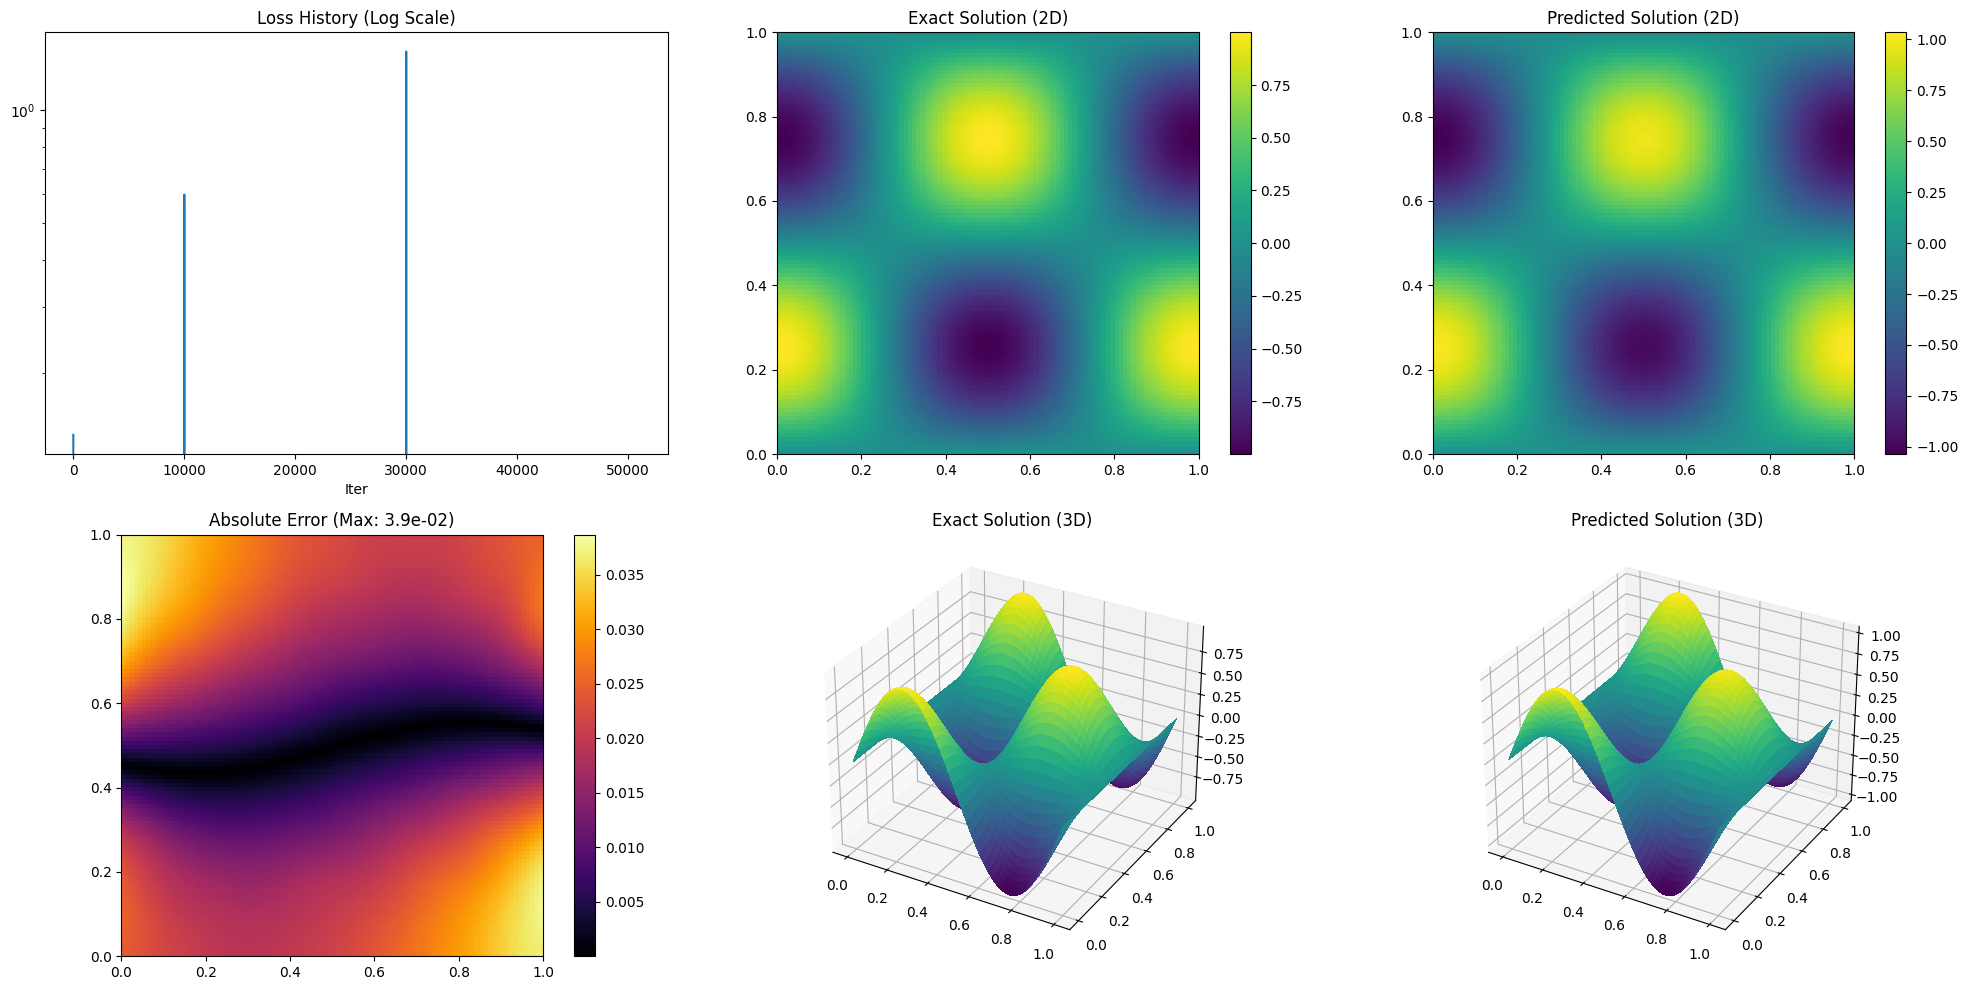

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import pickle

# ---------------------------------------------------------------------
# Configuration & Setup
# ---------------------------------------------------------------------
torch.set_default_dtype(torch.float64)
torch.manual_seed(42)
np.random.seed(42)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for High Precision
LAMBDA_BC_MAX = 1000.0     # Very high penalty for strict BC
LAMBDA_MEAN_MAX = 500.0    # Strict mean constraint
EPOCHS_ADAM = 50000        # Extended training for convergence
EPOCHS_LBFGS = 1000        # Deep polish
LR_MAX = 5e-4              # For Cosine Annealing
NUM_POINTS_DOMAIN = 10000  # Sobol points
NUM_POINTS_BOUNDARY = 4000 # Sobol points
SCALE = 1.0 / (8.0 * np.pi**4) # ~1.28e-3

# ---------------------------------------------------------------------
# 1. Neural Network (SIREN)
# ---------------------------------------------------------------------
class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, omega_0=1.0, is_first=False):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.linear = nn.Linear(in_features, out_features)
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.linear.in_features, 
                                             1 / self.linear.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.linear.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.linear.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

class DeepRitzNet(nn.Module):
    def __init__(self, num_layers=3, hidden_size=64):
        super(DeepRitzNet, self).__init__()
        # Use omega_0=1.0, assuming input is scaled by 2*pi
        layers = [SineLayer(2, hidden_size, is_first=True, omega_0=1.0)]
        for _ in range(num_layers):
            layers.append(SineLayer(hidden_size, hidden_size, omega_0=1.0))
        self.net = nn.Sequential(*layers)
        self.final_linear = nn.Linear(hidden_size, 1)
        
        with torch.no_grad():
            self.final_linear.weight.uniform_(-np.sqrt(6 / hidden_size) / 1.0, 
                                               np.sqrt(6 / hidden_size) / 1.0)
            
        self.n_L = sum(p.numel() for p in self.parameters() if p.requires_grad)

    def forward(self, x):
        # Scale [0,1] -> [0, 2pi] for SIREN
        return self.final_linear(self.net(2.0 * np.pi * x))

# ---------------------------------------------------------------------
# 2. Problem Definition (Exact Data)
# ---------------------------------------------------------------------
def exact_u_func(x):
    # u = sin(2*pi*x1) * cos(2*pi*x2)
    return torch.sin(2 * np.pi * x[:, 0:1]) * torch.cos(2 * np.pi * x[:, 1:2])

def get_exact_data(x, n=None):
    x.requires_grad_(True)
    u = exact_u_func(x)
    
    grad_u = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    
    u_xx = torch.autograd.grad(grad_u[:, 0:1], x, grad_outputs=torch.ones_like(grad_u[:, 0:1]), create_graph=True)[0][:, 0:1]
    u_yy = torch.autograd.grad(grad_u[:, 1:2], x, grad_outputs=torch.ones_like(grad_u[:, 1:2]), create_graph=True)[0][:, 1:2]
    lap_u = u_xx + u_yy
    
    grad_lap_u = torch.autograd.grad(lap_u, x, grad_outputs=torch.ones_like(lap_u), create_graph=True)[0]
    
    lap_u_xx = torch.autograd.grad(grad_lap_u[:, 0:1], x, grad_outputs=torch.ones_like(grad_lap_u[:, 0:1]), create_graph=True)[0][:, 0:1]
    lap_u_yy = torch.autograd.grad(grad_lap_u[:, 1:2], x, grad_outputs=torch.ones_like(grad_lap_u[:, 1:2]), create_graph=True)[0][:, 1:2]
    bilap_u = lap_u_xx + lap_u_yy
    
    f_val = bilap_u.detach()
    g1_val = None; g2_val = None
    
    if n is not None:
        g1_val = torch.sum(grad_u * n, dim=1, keepdim=True).detach()
        g2_val = torch.sum(grad_lap_u * n, dim=1, keepdim=True).detach()
        
    return f_val, g1_val, g2_val

# ---------------------------------------------------------------------
# 3. Loss Function (Standard PDF)
# ---------------------------------------------------------------------
def compute_model_derivatives(u, x):
    grad_u = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(grad_u[:, 0:1], x, grad_outputs=torch.ones_like(grad_u[:, 0:1]), create_graph=True)[0][:, 0:1]
    u_yy = torch.autograd.grad(grad_u[:, 1:2], x, grad_outputs=torch.ones_like(grad_u[:, 1:2]), create_graph=True)[0][:, 1:2]
    lap_u = u_xx + u_yy
    return grad_u, lap_u

def loss_function(model, x_domain, x_boundary, n_boundary, f_exact, g1_exact, g2_exact, lambda_bc, lambda_mean):
    # Domain
    x_domain.requires_grad_(True)
    u_domain = model(x_domain)
    _, lap_u_domain = compute_model_derivatives(u_domain, x_domain)
    energy_domain = 0.5 * (lap_u_domain ** 2) - f_exact * u_domain
    loss_domain = torch.mean(energy_domain)
    
    # Mean Constraint
    mean_u = torch.mean(u_domain)
    loss_mean = 0.5 * lambda_mean * (mean_u ** 2)
    
    # Boundary
    x_boundary.requires_grad_(True)
    u_boundary = model(x_boundary)
    grad_u_boundary, _ = compute_model_derivatives(u_boundary, x_boundary)
    du_dn = torch.sum(grad_u_boundary * n_boundary, dim=1, keepdim=True)
    
    term_g2 = g2_exact * u_boundary
    term_g1 = 0.5 * lambda_bc * (du_dn - g1_exact) ** 2
    loss_boundary = torch.mean(term_g2 + term_g1)
    
    return loss_domain + loss_mean + 4.0 * loss_boundary, mean_u

# ---------------------------------------------------------------------
# 4. Sobol Sampling (Better than Random)
# ---------------------------------------------------------------------
def get_sobol_domain_points(n):
    # Sobol engine for 2D domain
    sobol = torch.quasirandom.SobolEngine(dimension=2, scramble=True)
    return sobol.draw(n).to(DEVICE).to(torch.float64)

def get_sobol_boundary_points(n):
    # Generate 1D Sobol points for boundary parameterization
    sobol = torch.quasirandom.SobolEngine(dimension=1, scramble=True)
    # Split n into 4 sides
    n_side = n // 4
    t = sobol.draw(n_side).to(DEVICE).to(torch.float64).flatten()
    zeros = torch.zeros_like(t)
    ones = torch.ones_like(t)
    
    # Bottom (y=0), Top (y=1), Left (x=0), Right (x=1)
    x_b = torch.stack([t, zeros], 1); n_b = torch.tensor([[0., -1.]], device=DEVICE).repeat(n_side, 1)
    x_t = torch.stack([t, ones], 1);  n_t = torch.tensor([[0., 1.]], device=DEVICE).repeat(n_side, 1)
    x_l = torch.stack([zeros, t], 1); n_l = torch.tensor([[-1., 0.]], device=DEVICE).repeat(n_side, 1)
    x_r = torch.stack([ones, t], 1);  n_r = torch.tensor([[1., 0.]], device=DEVICE).repeat(n_side, 1)
    
    return torch.cat([x_b, x_t, x_l, x_r], 0), torch.cat([n_b, n_t, n_l, n_r], 0)

# ---------------------------------------------------------------------
# 5. Training
# ---------------------------------------------------------------------
def main():
    model = DeepRitzNet(num_layers=3, hidden_size=64).to(DEVICE)
    print(f"--- Network ---\n{model}")
    print(f"Params: {model.n_L}")
    print(f"Technique: SIREN + Sobol Sampling + CosineAnnealing")
    
    optimizer_adam = optim.Adam(model.parameters(), lr=LR_MAX)
    # Cosine Annealing with Warm Restarts (helps escape local minima)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_adam, T_0=10000, T_mult=2, eta_min=1e-6)
    
    optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=0.5, max_iter=EPOCHS_LBFGS,
                                  history_size=100, tolerance_grad=1e-9, tolerance_change=1e-11,
                                  line_search_fn="strong_wolfe")
    
    loss_history = []
    
    print("Running Adam (Sobol Sampling)...")
    for epoch in range(1, EPOCHS_ADAM + 1):
        # Curriculum
        if epoch <= 10000:
            alpha = epoch / 10000.0
            cur_lambda_bc = 1.0 + alpha * (LAMBDA_BC_MAX - 1.0)
            cur_lambda_mean = 1.0 + alpha * (LAMBDA_MEAN_MAX - 1.0)
        else:
            cur_lambda_bc = LAMBDA_BC_MAX
            cur_lambda_mean = LAMBDA_MEAN_MAX
            
        # Resample using Sobol (lower variance than random)
        x_dom = get_sobol_domain_points(NUM_POINTS_DOMAIN)
        x_bnd, n_bnd = get_sobol_boundary_points(NUM_POINTS_BOUNDARY)
        f_dom_exact, _, _ = get_exact_data(x_dom)
        _, g1_bnd_exact, g2_bnd_exact = get_exact_data(x_bnd, n_bnd)
        
        optimizer_adam.zero_grad()
        loss_raw, mean_val = loss_function(model, x_dom, x_bnd, n_bnd, 
                                           f_dom_exact, g1_bnd_exact, g2_bnd_exact,
                                           cur_lambda_bc, cur_lambda_mean)
        
        loss = loss_raw * SCALE
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer_adam.step()
        scheduler.step()
        
        loss_history.append(loss.item())
        
        if epoch % 2500 == 0:
            current_lr = optimizer_adam.param_groups[0]['lr']
            print(f"Epoch {epoch}/{EPOCHS_ADAM} Loss:{loss.item():.5f} Mean:{mean_val.item():.2e} LR:{current_lr:.1e}")

    # LBFGS Polish (Use a fixed high-quality Sobol set)
    print("Running LBFGS polish...")
    x_dom = get_sobol_domain_points(20000) # Dense fixed set
    x_bnd, n_bnd = get_sobol_boundary_points(8000)
    f_dom_exact, _, _ = get_exact_data(x_dom)
    _, g1_bnd_exact, g2_bnd_exact = get_exact_data(x_bnd, n_bnd)
    
    def closure():
        optimizer_lbfgs.zero_grad()
        loss_raw, _ = loss_function(model, x_dom, x_bnd, n_bnd, 
                                    f_dom_exact, g1_bnd_exact, g2_bnd_exact,
                                    LAMBDA_BC_MAX, LAMBDA_MEAN_MAX)
        loss = loss_raw * SCALE
        loss.backward()
        loss_history.append(loss.item())
        return loss
    optimizer_lbfgs.step(closure)
    
    # ---------------------------------------------------------------------
    # 6. Evaluation & Plotting
    # ---------------------------------------------------------------------
    print("\n--- Computing Errors ---")
    n_test = 100
    x1 = torch.linspace(0, 1, n_test)
    x2 = torch.linspace(0, 1, n_test)
    X, Y = torch.meshgrid(x1, x2, indexing='ij')
    x_test = torch.stack([X.flatten(), Y.flatten()], dim=1).to(DEVICE)
    x_test.requires_grad_(True)
    
    u_exact = exact_u_func(x_test)
    u_pred = model(x_test)
    
    # Derivatives for H1/H2
    grad_u_pred = torch.autograd.grad(u_pred, x_test, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    grad_u_exact = torch.autograd.grad(u_exact, x_test, grad_outputs=torch.ones_like(u_exact), create_graph=True)[0]
    
    def get_hessian(u, x):
        grads = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        ux, uy = grads[:,0:1], grads[:,1:2]
        return torch.cat([
            torch.autograd.grad(ux, x, grad_outputs=torch.ones_like(ux), create_graph=True)[0][:,0:1], # uxx
            torch.autograd.grad(ux, x, grad_outputs=torch.ones_like(ux), create_graph=True)[0][:,1:2], # uxy
            torch.autograd.grad(uy, x, grad_outputs=torch.ones_like(uy), create_graph=True)[0][:,0:1], # uyx
            torch.autograd.grad(uy, x, grad_outputs=torch.ones_like(uy), create_graph=True)[0][:,1:2]  # uyy
        ], dim=1)

    hess_pred = get_hessian(u_pred, x_test)
    hess_exact = get_hessian(u_exact, x_test)
    
    # Error Metrics
    mse_u = torch.mean((u_pred - u_exact)**2).item()
    mse_grad = torch.mean(torch.sum((grad_u_pred - grad_u_exact)**2, dim=1)).item()
    mse_hess = torch.mean(torch.sum((hess_pred - hess_exact)**2, dim=1)).item()
    
    norm_u = torch.mean(u_exact**2).item()
    norm_grad = torch.mean(torch.sum(grad_u_exact**2, dim=1)).item()
    norm_hess = torch.mean(torch.sum(hess_exact**2, dim=1)).item()
    
    l2_err = np.sqrt(mse_u)
    h1_err = np.sqrt(mse_u + mse_grad)
    h2_err = np.sqrt(mse_u + mse_grad + mse_hess)
    
    l2_rel = l2_err / np.sqrt(norm_u)
    h1_rel = h1_err / np.sqrt(norm_u + norm_grad)
    h2_rel = h2_err / np.sqrt(norm_u + norm_grad + norm_hess)
    
    print(f"L2 Error: {l2_err:.4e} (Rel: {l2_rel:.4e})")
    print(f"H1 Error: {h1_err:.4e} (Rel: {h1_rel:.4e})")
    print(f"H2 Error: {h2_err:.4e} (Rel: {h2_rel:.4e})")
    
    # Save Data
    with open("loss_history.pkl", "wb") as f: pickle.dump(loss_history, f)
    torch.save(model.state_dict(), "drm_model.pth")

    # ---------------------------------------------------------------------
    # PLOTTING
    # ---------------------------------------------------------------------
    u_pred_np = u_pred.detach().cpu().numpy().reshape(n_test, n_test)
    u_exact_np = u_exact.detach().cpu().numpy().reshape(n_test, n_test)
    X_np = X.detach().cpu().numpy()
    Y_np = Y.detach().cpu().numpy()
    
    fig = plt.figure(figsize=(20, 10))
    
    # 1. Loss
    ax1 = fig.add_subplot(2, 3, 1)
    ax1.plot(loss_history)
    ax1.set_title("Loss History (Log Scale)")
    ax1.set_yscale('log')
    ax1.set_xlabel("Iter")
    
    # 2. 2D Exact Heatmap
    ax2 = fig.add_subplot(2, 3, 2)
    im2 = ax2.imshow(u_exact_np, extent=[0,1,0,1], origin='lower', cmap='viridis')
    ax2.set_title("Exact Solution (2D)")
    plt.colorbar(im2, ax=ax2)
    
    # 3. 2D Predicted Heatmap
    ax3 = fig.add_subplot(2, 3, 3)
    im3 = ax3.imshow(u_pred_np, extent=[0,1,0,1], origin='lower', cmap='viridis')
    ax3.set_title("Predicted Solution (2D)")
    plt.colorbar(im3, ax=ax3)
    
    # 4. 2D Error Heatmap
    ax4 = fig.add_subplot(2, 3, 4)
    im4 = ax4.imshow(np.abs(u_pred_np - u_exact_np), extent=[0,1,0,1], origin='lower', cmap='inferno')
    ax4.set_title(f"Absolute Error (Max: {np.max(np.abs(u_pred_np - u_exact_np)):.1e})")
    plt.colorbar(im4, ax=ax4)
    
    # 5. 3D Surface Exact
    ax5 = fig.add_subplot(2, 3, 5, projection='3d')
    surf = ax5.plot_surface(X_np, Y_np, u_exact_np, cmap='viridis', linewidth=0, antialiased=False)
    ax5.set_title("Exact Solution (3D)")
    
    # 6. 3D Surface Predicted
    ax6 = fig.add_subplot(2, 3, 6, projection='3d')
    surf = ax6.plot_surface(X_np, Y_np, u_pred_np, cmap='viridis', linewidth=0, antialiased=False)
    ax6.set_title("Predicted Solution (3D)")
    
    plt.tight_layout()
    plt.savefig("drm_p4_full_analysis.png")
    plt.show()

if __name__ == "__main__":
    main()